# Song of the Week – Logistic Regression Model Comparison

In this notebook we compare three levels of feature complexity for a Logistic Regression model:

1. **Static metadata only** – simple track-level info (e.g. popularity, duration).
2. **Static metadata + genre OHE** – adds high-level "what kind of track is this".
3. **Full engineered features** – weekly behaviour, history, release recency, and genre OHE.

The goal is to understand how much each layer of features improves our ability to predict the weekly favourite, using a **time-based split** and **PR-AUC / ROC-AUC** as main metrics.


In [32]:
from pathlib import Path
import os, sys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve, 
    classification_report, 
    confusion_matrix
)
from sklearn.model_selection import train_test_split

# move working dir from notebooks/ -> repo root and expose it to Python
repo_root = Path.cwd().parent
os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from common.config_manager import ConfigManager
from common.utils.io import read_csv
from core.features.featurize import (
    get_label_start_dt,
    filter_label_period,
    impute_days_since_release,
    drop_leaky_columns,
    remove_high_corr_features,
    select_feature_columns,
    fit_dv_ohe,
    transform_dv_ohe,
)


In [13]:
# Import ConfigManager, that handles all configurations and file paths
config_manager = ConfigManager(Path.cwd())

# Project config
project_cfg = config_manager.project()

paths = project_cfg["paths"]
processed_dir = Path(paths["core_processed"])
weekly_path = processed_dir / "weekly_table.csv"

# Variables
TARGET_COL = "is_week_favorite"
DATE_COL = "week_saturday_dt"


weekly_path


WindowsPath('core/data/processed/weekly_table.csv')

## Load weekly data and build a clean modeling view

We start from the **weekly table** with Core V1 features and metadata.  
From there, we:

- Filter to the label period (using `modeling.label_start_saturday_utc`).
- Impute `days_since_release`.
- Drop leaky listener/playcount columns.
- Drop a fixed set of highly correlated features.

At this stage we **do not** apply any OHE yet – that will be done later, after splitting.


In [3]:
# Load weekly table with all Core V1 features and metadata
df_weekly = read_csv(weekly_path, safe=True)

# Filter to label period (uses modeling.label_start_saturday_utc from project.yaml)
label_start_dt = get_label_start_dt(project_cfg)
df_model = filter_label_period(df_weekly, label_start_dt)

# Impute days_since_release and add *_was_missing flag
df_model = impute_days_since_release(df_model)

# Drop leaky listener/playcount columns
df_model = drop_leaky_columns(df_model)

# Drop explicitly redundant high-correlation features
df_model = remove_high_corr_features(df_model)

df_model[[DATE_COL, TARGET_COL]].describe(include="all")


,week_saturday_dt,is_week_favorite
count,96112,96112.000000
mean,2023-01-27 12:47:50.351256576+00:00,0.002622
min,2021-01-02 00:00:00+00:00,0.000000
25%,2021-10-09 00:00:00+00:00,0.000000
50%,2022-11-19 00:00:00+00:00,0.000000
75%,2024-04-13 00:00:00+00:00,0.000000
max,2025-11-15 00:00:00+00:00,1.000000
std,NaN,0.051138


## Time-based train / validation / test split

To respect chronology, we split by **week** instead of random rows.

We use a **60 / 20 / 20** split:

- Train: earliest 60% of weeks.
- Validation: next 20%.
- Test: latest 20%.

In [14]:
df_model[DATE_COL] = pd.to_datetime(
    df_model[DATE_COL],
    utc=True,
    errors="coerce",
)

# Sort unique weeks and define cut points for 60 / 20 / 20 splits
weeks = (
    df_model[DATE_COL]
    .sort_values()
    .unique()
)
n_weeks = len(weeks)

train_weeks_end = weeks[int(0.6 * n_weeks)]
val_weeks_end = weeks[int(0.8 * n_weeks)]

train_mask = df_model[DATE_COL] <= train_weeks_end
val_mask = (df_model[DATE_COL] > train_weeks_end) & (df_model[DATE_COL] <= val_weeks_end)
test_mask = df_model[DATE_COL] > val_weeks_end

df_train = df_model.loc[train_mask].reset_index(drop=True)
df_val = df_model.loc[val_mask].reset_index(drop=True)
df_test = df_model.loc[test_mask].reset_index(drop=True)

def _pos_rate(s: pd.Series) -> float:
    return float(s.mean()) if len(s) else float("nan")

print("Rows (train / val / test):", len(df_train), len(df_val), len(df_test))
print(
    "Positive rate (train / val / test): "
    f"{_pos_rate(df_train['is_week_favorite']):.4f} / "
    f"{_pos_rate(df_val['is_week_favorite']):.4f} / "
    f"{_pos_rate(df_test['is_week_favorite']):.4f}"
)


Rows (train / val / test): 66187 15363 14562
Positive rate (train / val / test): 0.0023 / 0.0033 / 0.0034


## One-Hot Encoding for genres (train-only)

For the main experiments, we use:

- **Static metadata baselines**: with and without genre OHE.
- **Full engineered model**: weekly behaviour + history + release features + genre OHE.

To avoid leakage, we:

- Fit the `DictVectorizer` for `genre_bucket` on **train only**.
- Apply the fitted vectorizer to validation and test.


In [15]:
# Fit DictVectorizer-based OHE on train only (genre_bucket)
df_train_ohe, dv_genre, genre_cols = fit_dv_ohe(
    df_train,
    column="genre_bucket",
    min_freq=20,
    prefix="genre",
    keep_original=True,
)

# Apply the same DV to val and test (unseen levels -> all-zero across genre__* columns)
df_val_ohe = transform_dv_ohe(
    df_val,
    dv_genre,
    column="genre_bucket",
    prefix="genre",
    keep_original=True,
)
df_test_ohe = transform_dv_ohe(
    df_test,
    dv_genre,
    column="genre_bucket",
    prefix="genre",
    keep_original=True,
)

# Targets
y_train = df_train_ohe[TARGET_COL].values
y_val = df_val_ohe[TARGET_COL].values
y_test = df_test_ohe[TARGET_COL].values

len(genre_cols), y_train.mean(), y_val.mean(), y_test.mean()


(14, 0.0022965234864852613, 0.0033196641280999807, 0.003364922400769125)

## Evaluation helper

We’ll compare models using:

- **ROC-AUC** - how well the model ranks positives above negatives.
- **PR-AUC (Average Precision)** - how good the precision–recall trade-off is, which matters more here given the strong imbalance.


In [6]:
def evaluate_model(name, model, X, y):
    """
    Simple helper to print ROC-AUC and PR-AUC on a given split.
    """
    p = model.predict_proba(X)[:, 1]
    roc = roc_auc_score(y, p)
    pr = average_precision_score(y, p)
    print(f"{name:22s} | ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")


## Baseline 1 – Static metadata only

First, we train a Logistic Regression that only sees the original track metadata with positive correlation with is_week_favorite:

- `track_duration`
- `spotify_popularity`


In [23]:
# Original metadata columns (
base_cols = [
    "track_duration",
    "spotify_popularity",
]
base_cols = [c for c in base_cols if c in df_train_ohe.columns]

print("Baseline static metadata columns:", base_cols)

if not base_cols:
    raise ValueError("No static metadata columns found for baseline 1.")

X_train_base = df_train_ohe[base_cols].values
X_val_base = df_val_ohe[base_cols].values
X_test_base = df_test_ohe[base_cols].values

logreg_base = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
)

logreg_base.fit(X_train_base, y_train)

print("Validation performance – Baseline 1 (static metadata only):")
evaluate_model("logreg_base_static   ", logreg_base, X_val_base, y_val)


Baseline static metadata columns: ['track_duration', 'spotify_popularity']
Validation performance – Baseline 1 (static metadata only):
logreg_base_static     | ROC-AUC: 0.556 | PR-AUC: 0.005


## Baseline 2 – Static metadata + genre OHE

Next, we keep the same static metadata and **add genre OHE**:

- `track_duration`
- `spotify_popularity`
- all `genre__*` columns

The OHE was applied on `genre_bucket`column, which was a grouping of the original `spotify_genres` column


In [24]:
# Baseline 2: static metadata + all genre OHE columns
base_cols_static = [c for c in base_cols if c in df_train_ohe.columns]
genre_ohe_cols = [c for c in df_train_ohe.columns if c.startswith("genre__")]

base_cols_static_genre = base_cols_static + genre_ohe_cols

print("Baseline + genre columns (sample):", base_cols_static_genre)
print(f"Total baseline+genre features: {len(base_cols_static_genre)}")


X_train_base_genre = df_train_ohe[base_cols_static_genre].values
X_val_base_genre = df_val_ohe[base_cols_static_genre].values
X_test_base_genre = df_test_ohe[base_cols_static_genre].values

logreg_base_genre = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
)

logreg_base_genre.fit(X_train_base_genre, y_train)

print("\nValidation performance – Baseline 2 (static + genre):")
evaluate_model("logreg_base_static   ", logreg_base,       X_val_base,       y_val)
evaluate_model("logreg_base_meta+genre   ", logreg_base_genre, X_val_base_genre, y_val)

Baseline + genre columns (sample): ['track_duration', 'spotify_popularity', 'genre__classical_art', 'genre__electronic_dance', 'genre__experimental_avant', 'genre__folk_country_americana', 'genre__hip_hop_rap', 'genre__jazz', 'genre__latin', 'genre__metal_hard', 'genre__other', 'genre__pop', 'genre__rnb_soul', 'genre__rock', 'genre__unknown', 'genre__world_regional']
Total baseline+genre features: 16

Validation performance – Baseline 2 (static + genre):
logreg_base_static     | ROC-AUC: 0.556 | PR-AUC: 0.005
logreg_base_meta+genre    | ROC-AUC: 0.560 | PR-AUC: 0.004


## Full engineered model – Core V1 features + release + genre OHE

Finally, we use the **full feature set**:

- **Static metadata**
  - `track_duration` - length of the track (in seconds), captures typical song length patterns.
  - `spotify_popularity` - Spotify popularity score (0–100), a proxy for how broadly listened the track is overall.
- **Core V1 weekly features**
  - weekly intensity (`scrobbles_week`, `unique_days_week`)
  - end-of-week bias (`scrobbles_last_fri_sat`, `scrobbles_saturday`, `last_scrobble_gap_days`)
  - novelty/history (`first_seen_week`, `prior_scrobbles_all_time`)
  - momentum (`scrobbles_prev_1w`, `scrobbles_prev_4w`, `week_over_week_change`, `momentum_4w_ratio`).
- **Release recency**
  - `days_since_release` and any `released_within_*d` flags, capturing how “new” the track is at that week.
- **Genre OHE**
  - All `genre__*` dummy columns derived from `genre_bucket` (frequent genres kept as separate columns, rare ones collapsed to `other`).


In [25]:
# Use select_feature_columns to get the full engineered feature list
feat_cols_train = select_feature_columns(df_train_ohe)
feat_cols_val = select_feature_columns(df_val_ohe)
feat_cols_test = select_feature_columns(df_test_ohe)

common_feats = sorted(set(feat_cols_train) & set(feat_cols_val) & set(feat_cols_test))

X_train_full = df_train_ohe[common_feats].values
X_val_full = df_val_ohe[common_feats].values
X_test_full = df_test_ohe[common_feats].values

logreg_full = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
)

logreg_full.fit(X_train_full, y_train)

print("Validation performance – full vs baselines:")
evaluate_model("logreg_base_static   ", logreg_base,        X_val_base,        y_val)
evaluate_model("logreg_base_meta+g   ", logreg_base_genre,  X_val_base_genre,  y_val)
evaluate_model("logreg_full_plain    ", logreg_full,        X_val_full,        y_val)

Validation performance – full vs baselines:
logreg_base_static     | ROC-AUC: 0.556 | PR-AUC: 0.005
logreg_base_meta+g     | ROC-AUC: 0.560 | PR-AUC: 0.004
logreg_full_plain      | ROC-AUC: 0.984 | PR-AUC: 0.386


## ROC curves – Baselines vs full engineered model

Here we compare the ROC curves of the three models on the **validation** split:

- Baseline 1 – static metadata only
- Baseline 2 – static metadata + genre OHE
- Full model – engineered features + genre OHE

This helps visualize how each model ranks positives vs negatives across all thresholds.


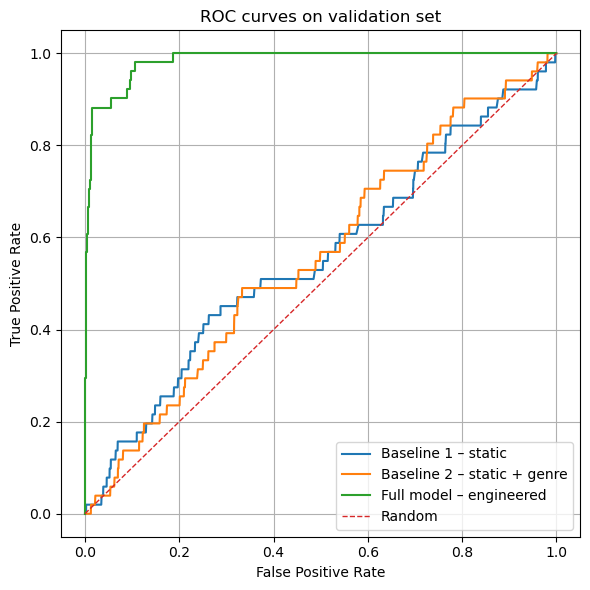

In [26]:
def get_roc_points(model, X, y):
    """Return FPR and TPR arrays for a given model and dataset."""
    p = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, p)
    return fpr, tpr

fpr_base, tpr_base  = get_roc_points(logreg_base, X_val_base, y_val)
fpr_base_genre, tpr_base_genre = get_roc_points(logreg_base_genre, X_val_base_genre, y_val)
fpr_full, tpr_full = get_roc_points(logreg_full, X_val_full, y_val)

plt.figure(figsize=(6, 6))

plt.plot(fpr_base, tpr_base, label="Baseline 1 – static")
plt.plot(fpr_base_genre, tpr_base_genre, label="Baseline 2 – static + genre")
plt.plot(fpr_full, tpr_full, label="Full model – engineered")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves on validation set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Parameter Tuning 



The Logistic Regression model has two maiparameterss” we care about:

1. **Regularization strength (C)** – controls how complex the model is for a fixed feature set.
2. **Decision threshold** – turns predicted probabilities into a hard “favorite / not favorite” label.

We tune them in two stages:

- First, we fix the feature set and search over a small grid of **C values**, using **validation ROC-AUC and PR-AUC** to pick a good regularization level.
- Then, with C fixed, we tune the **probability threshold** on the validation set by looking at the **F1 score** across th threshold.


## C Tuning

To keep things simple, we tune only **C** (inverse regularization strength) for the full-feature Logistic Regression.

We train the model for a small set of C values and look at:

- ROC-AUC on validation
- PR-AUC on validation

This gives a quick sense of where the model performs best without an exhaustive search.


In [19]:
# Grid of C values to try (log scale)
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]

tuning_results = []

for C in C_values:
    model = LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1,
        random_state=42,
        C=C,
    )
    model.fit(X_train_full, y_train)

    p_val = model.predict_proba(X_val_full)[:, 1]
    roc = roc_auc_score(y_val, p_val)
    pr = average_precision_score(y_val, p_val)

    tuning_results.append({"C": C, "roc_auc": roc, "pr_auc": pr})

tuning_df = pd.DataFrame(tuning_results)
tuning_df


,C,roc_auc,pr_auc
0,0.01,0.983421,0.404483
1,0.10,0.984130,0.392342
2,1.00,0.983960,0.385792
3,10.00,0.983335,0.378626
4,100.00,0.983113,0.373341


### Visualizing C vs ROC-AUC / PR-AUC

The plot below shows how ROC-AUC and PR-AUC change as we vary **C**.  
We use a log scale on the x-axis.


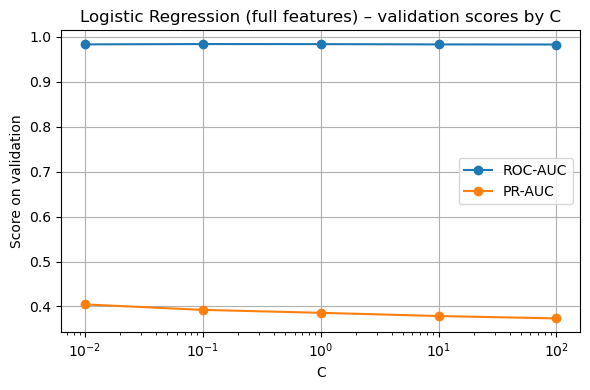

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(tuning_df["C"], tuning_df["roc_auc"], marker="o", label="ROC-AUC")
ax.plot(tuning_df["C"], tuning_df["pr_auc"],  marker="o", label="PR-AUC")

ax.set_xscale("log")
ax.set_xlabel("C")
ax.set_ylabel("Score on validation")
ax.set_title("Logistic Regression (full features) – validation scores by C")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


### Decision - C

We'll use `C=0.01` since it provides the best PR_AUC value (which is the primary metric due to class imbalance)

In [29]:
best_C = 0.01

## Threshold tuning

The model outputs probabilities, not hard labels.

To turn scores into "favorite / not favorite", we choose a probability threshold.
Here we:
- train a Logistic Regression with **C = 0.01** on the **train** split,
- sweep thresholds on the **validation** split using the precision–recall curve,
- pick the threshold that maximizes **F1**,
- and later apply this threshold to the final train+val model on the test set.


Best threshold on validation (max F1): 0.1521
  Precision: 0.411
  Recall   : 0.588
  F1       : 0.484


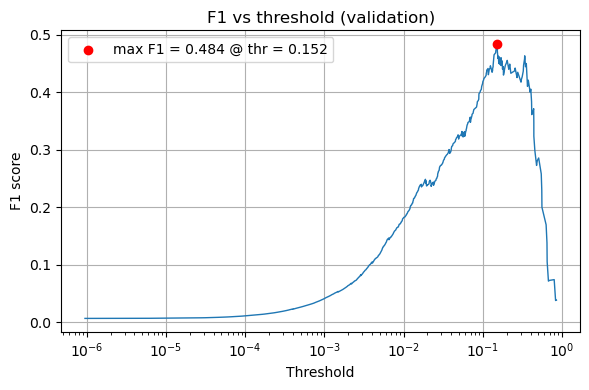

In [42]:
# Model trained only on train for threshold selection
logreg_for_threshold = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
    C=best_C,
)
logreg_for_threshold.fit(X_train_full, y_train)

# Validation scores
p_val = logreg_for_threshold.predict_proba(X_val_full)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, p_val)

# Compute F1 for each candidate threshold (skip the last precision/recall point)
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold on validation (max F1): {best_threshold:.4f}")
print(f"  Precision: {precision[best_idx]:.3f}")
print(f"  Recall   : {recall[best_idx]:.3f}")
print(f"  F1       : {f1_scores[best_idx]:.3f}")

# Plot F1 vs threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, linewidth=1)
plt.scatter(
    thresholds[best_idx],
    f1_scores[best_idx],
    color="red",
    zorder=3,
    label=f"max F1 = {f1_scores[best_idx]:.3f} @ thr = {best_threshold:.3f}",
)

plt.xscale("log")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 vs threshold (validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Decision - Threshold

We'll use `threshold=0.152` since it provides the best F1 value

In [44]:
best_threshold=0.152

## Final Logistic Regression model - train + validation, then test evaluation

We now fix the final configuration:

- Logistic Regression with the **full engineered feature set**

We retrain this model on **train + validation** and then evaluate it **once** on the held-out test set.


In [28]:
# Stack train and validation for the final fit
X_trainval_full = np.vstack([X_train_full, X_val_full])
y_trainval = np.concatenate([y_train, y_val])

best_C = 0.01

logreg_full_final = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42,
    C=best_C,
)

logreg_full_final.fit(X_trainval_full, y_trainval)

print("Final model configuration:")
print(f"  Features: full engineered set ({X_train_full.shape[1]} features)")
print(f"  C: {best_C}")

print("\nTest performance – final model (train+val → test):")
evaluate_model("logreg_full_final", logreg_full_final, X_test_full, y_test)

Final model configuration:
  Features: full engineered set (28 features)
  C: 0.01

Test performance – final model (train+val → test):
logreg_full_final      | ROC-AUC: 0.984 | PR-AUC: 0.256
